In [27]:
# Import libraries

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL  # Python Imaging Library (PIL)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [28]:
# Download and explore the dataset

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [29]:
# Count total image

# All subfolders, then all jpg files
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


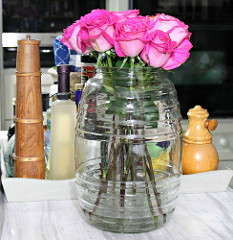

In [30]:
# look into only "roses" subfolder
import glob
roses = list(data_dir.glob('roses/*'))
#roses = data_dir.glob('roses/*')
#PIL.Image.open(str(roses[0]))
PIL.Image.open(roses[0])
#for i in os.listdir(roses):
#  path = roses + "/" + i
#  im=PIL.Image.open(path)
#  plt.imshow(im)
#  plt.show()


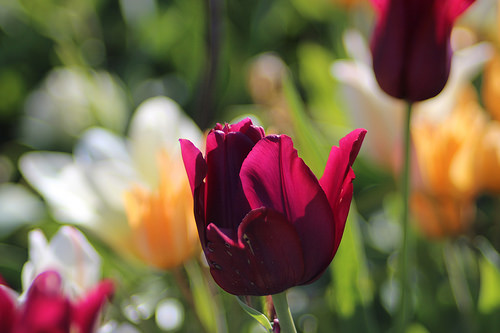

In [31]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

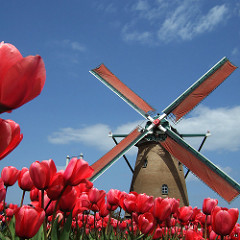

In [32]:
PIL.Image.open(str(tulips[1]))

In [33]:
# Create a dataset
# Set image size and number of images in each batch
 
batch_size = 32
img_height = 180
img_width = 180

In [34]:
# Data preprocessing
# Generates a tf.data.Dataset from image files in a directory by using tf.keras.preprocessing.image_dataset_from_directory.
# Split the image dataset into 8:2. Use 80% of the images for training, and 20% for validation


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [35]:
# check the class names in the class_names attribute on these datasets

class_names = train_ds.class_names
print(class_names)
val_class_names = val_ds.class_names
print(val_class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


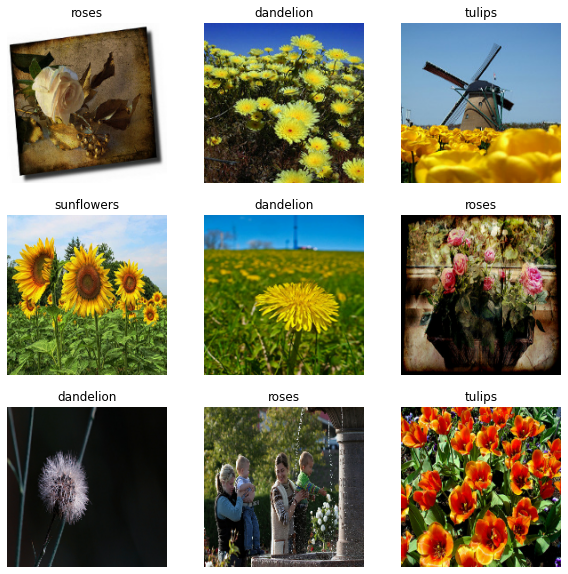

In [36]:
# Visualize the data
# Show 9 images from train dataset with image labels.

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [37]:
# The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). 
# The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

#print("Image Sahpe:", train_ds.shape)
for image_batch, labels_batch in train_ds:
  print("Image Shape with Batch:",image_batch.shape)
  print("Label batch Shape:",labels_batch.shape)
  break


Image Shape with Batch: (32, 180, 180, 3)
Label batch Shape: (32,)


In [38]:
# Configure the dataset for performance
# Use buffered prefetching to yield data from disk without having I/O become blocking
# Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model.
# Dataset.prefetch() overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [39]:
# Standardize the data
# Preprocess images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).
# All images will be rescaled by 1./255 (min-max normalization)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [43]:
# Create the model
# The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a relu activation function.

num_classes = 5

model = Sequential([
  # All images will be rescaled by 1./255 (min-max normalization)
  # Image shape is (180x180x3)
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # First convolution extracts 16 filters that are 3x3
  # Convolution is followed by max-pooling layer with a 2x2 window
  # Relu overcome vanishing gradient prolem, learning faster and better. Relu is default for Convolutional Neural Network.
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # Second convolution extracts 32 filters that are 3x3
  # Convolution is followed by max-pooling layer with a 2x2 window
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # Third convolution extracts 64 filters that are 3x3
  # Convolution is followed by max-pooling layer with a 2x2 window
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # Flatten feature map to a 1-dim tensor so we can add fully connected layers
  layers.Flatten(),

  # Create a fully connected layer with ReLU activation and 128 hidden units
  layers.Dense(128, activation='relu'),

  # Create output layer with five classifier
  layers.Dense(num_classes)
])


In [44]:
# Compile the model
# Using the optimizers.Adam optimizer and losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument.

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [45]:
# Model summary

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 22, 22, 64)       

In [46]:
# Train the model

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose = 2
)

Epoch 1/10
92/92 - 94s - loss: 1.3519 - accuracy: 0.4043 - val_loss: 1.1031 - val_accuracy: 0.5327
Epoch 2/10
92/92 - 92s - loss: 1.0090 - accuracy: 0.6059 - val_loss: 1.0414 - val_accuracy: 0.5858
Epoch 3/10
92/92 - 91s - loss: 0.8518 - accuracy: 0.6866 - val_loss: 0.9628 - val_accuracy: 0.6376
Epoch 4/10
92/92 - 92s - loss: 0.6505 - accuracy: 0.7646 - val_loss: 0.9290 - val_accuracy: 0.6553
Epoch 5/10
92/92 - 92s - loss: 0.4216 - accuracy: 0.8542 - val_loss: 1.0644 - val_accuracy: 0.6608
Epoch 6/10
92/92 - 92s - loss: 0.2777 - accuracy: 0.9063 - val_loss: 1.2110 - val_accuracy: 0.6253
Epoch 7/10
92/92 - 93s - loss: 0.1676 - accuracy: 0.9503 - val_loss: 1.2417 - val_accuracy: 0.6649
Epoch 8/10
92/92 - 92s - loss: 0.0883 - accuracy: 0.9762 - val_loss: 1.4376 - val_accuracy: 0.6090
Epoch 9/10
92/92 - 93s - loss: 0.0567 - accuracy: 0.9833 - val_loss: 1.7531 - val_accuracy: 0.6213
Epoch 10/10
92/92 - 92s - loss: 0.0652 - accuracy: 0.9819 - val_loss: 2.0188 - val_accuracy: 0.6185


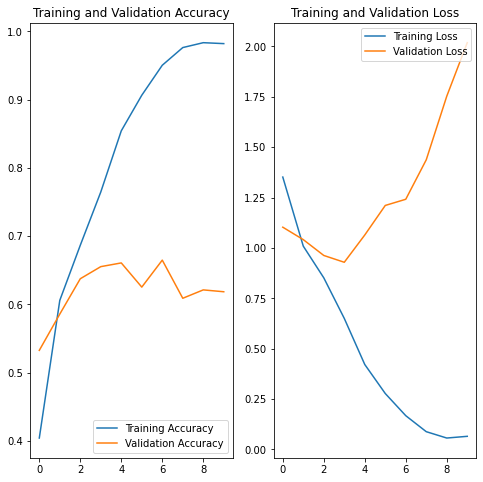

In [47]:
# Visualize training results
# Create plots of loss and accuracy on the training and validation sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [49]:
# print maximun accuracy or traning and validation data
# In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. 
# Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

print("Training Data Accuracy:",max(acc))
print("Validation Data Accuracy",max(val_acc))

Training Data Accuracy: 0.9833106398582458
Validation Data Accuracy 0.664850115776062


In [50]:
# Use data augmentation and add Dropout to your model to overcome "overfitting".
# Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images.
# Implement data augmentation using the layers from tf.keras.layers.experimental.preprocessing. These can be included inside ML model like other layers, and run on the GPU.

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


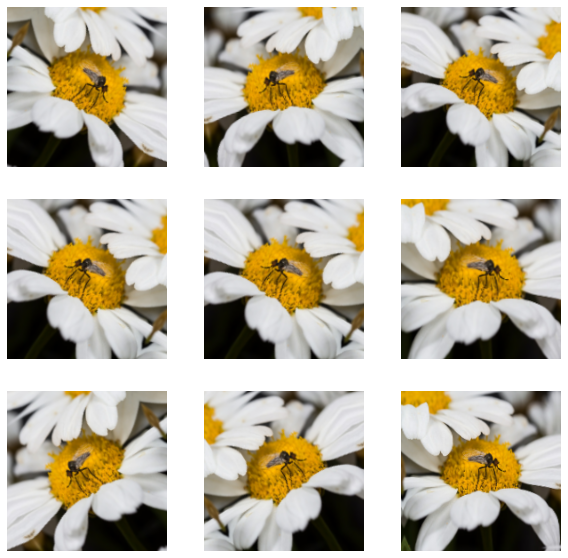

In [51]:
# Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [52]:
# Dropout
# When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. 
# Create a new neural network using layers.Dropout, then train it using augmented images.

num_classes =5

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # 20% dropout
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [53]:
# Compile and train the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
# Model summary

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)       

In [55]:
# Train the model

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose = 1
)

Epoch 1/15
92/92 [==============================] - 107s 1s/step - loss: 1.6069 - accuracy: 0.3072 - val_loss: 1.1468 - val_accuracy: 0.5163
Epoch 2/15
92/92 [==============================] - 104s 1s/step - loss: 1.1350 - accuracy: 0.5242 - val_loss: 1.0412 - val_accuracy: 0.6090
Epoch 3/15
92/92 [==============================] - 105s 1s/step - loss: 0.9903 - accuracy: 0.6162 - val_loss: 1.0357 - val_accuracy: 0.5913
Epoch 4/15
92/92 [==============================] - 105s 1s/step - loss: 0.9147 - accuracy: 0.6419 - val_loss: 0.8302 - val_accuracy: 0.6635
Epoch 5/15
92/92 [==============================] - 111s 1s/step - loss: 0.8192 - accuracy: 0.6814 - val_loss: 0.8405 - val_accuracy: 0.6744
Epoch 6/15
92/92 [==============================] - 106s 1s/step - loss: 0.7404 - accuracy: 0.7215 - val_loss: 0.8134 - val_accuracy: 0.6785
Epoch 7/15
92/92 [==============================] - 105s 1s/step - loss: 0.7092 - accuracy: 0.7314 - val_loss: 0.7751 - val_accuracy: 0.7003
Epoch 8/15
92

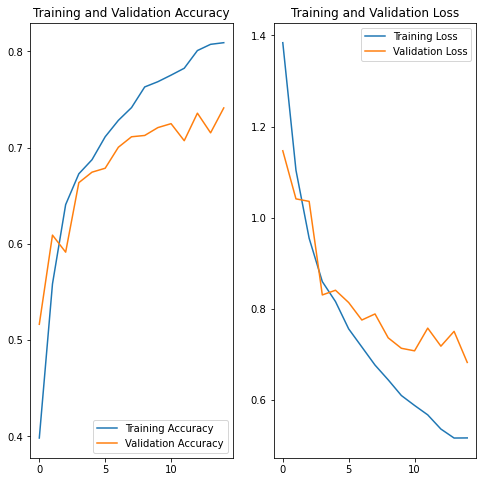

In [56]:
# After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [57]:
import statistics as st
print("Training Data Accuracy:",max(acc))
print("Validation Data Accuracy",max(val_acc))
print("Training Data Accuracy:",st.mean(acc))
print("Validation Data Accuracy",st.mean(val_acc))

Training Data Accuracy: 0.8089237213134766
Validation Data Accuracy 0.7411444187164307
Training Data Accuracy: 0.7095821976661683
Validation Data Accuracy 0.6801089922587077


In [58]:
# Predict on new data
# Note: Data augmentation and Dropout layers are inactive at inference time.

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch (of zero)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 99.31 percent confidence.
